In [437]:
import math
import numpy as np
import pandas as pd
import pickle
from statsmodels import tsa
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels import multivariate
from statsmodels import regression
import scipy.stats as stats
from statsmodels.sandbox.regression import gmm
from statsmodels.sandbox.regression.gmm import GMM
import statsmodels.stats.diagnostic as smd
from statsmodels.tsa.adfvalues import mackinnonp, mackinnoncrit
from statsmodels.tsa.stattools import adfuller
import statsmodels.tsa.api as smt
from statsmodels.tsa.vector_ar.hypothesis_test_results import CausalityTestResults
from statsmodels.tsa.vector_ar.var_model import VAR, VARProcess, VARResults
from statsmodels.tsa.vector_ar.vecm import VECM, coint_johansen, select_order
import statsmodels.tsa.arima_model as am
from statsmodels.regression.rolling import RollingOLS
from tabulate import tabulate
import datetime as dt
from dateutil.relativedelta import relativedelta
from datetime import timedelta
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter, MinuteLocator
from matplotlib.ticker import PercentFormatter
import os
import warnings
from scipy.optimize import minimize, brute
import panel as pn
import altair as alt
from altair import datum
import pandas as pd
import datetime as dt
from pandas_profiling import ProfileReport
import numpy as np
import os
import datetime
from os import listdir
import warnings
import plotly.figure_factory as ff
import numpy as np
import pandas as pd
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import altair as alt
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from scipy import stats

In [393]:
files=os.listdir("data//USData//")
HospitalData=pd.read_csv("data//covid19-Hospitals.csv")
populationData=pd.read_csv("data//PopulationUSState.csv")
populationData.columns=["state","population"]
populationData["population"]=populationData["population"].str.replace(',','').astype(float)
HospitalData["Inpatient_Bed_Capacity"]=HospitalData["Inpatient_Bed_Capacity"].astype(float)
HospitalData["InBedsOCC_NonCovid"]=HospitalData['InBedsOccAnyPat__Numbeds_Est']-HospitalData['InBedsOccCOVID__Numbeds_Est']
HospitalData["InICUOCC_NonCovid"]=HospitalData['InBedsOccAnyPat__Numbeds_Est']-HospitalData['InBedsOccCOVID__Numbeds_Est']

In [394]:
frames=[]
for file in files:
    df=pd.read_csv("data//USData//"+file)
    df['date']=pd.to_datetime(df['date'])
    df=df.fillna(0)
    df=df.sort_values(by='date',ascending=True)
    frames.append(df)
    #print(df.shape)
final=pd.concat(frames)

In [395]:
StatwiseBeds=HospitalData.groupby(["state"])["Inpatient_Bed_Capacity","ICU_Bed_total_estimate_Capacity","InBedsOCC_NonCovid","InICUOCC_NonCovid"].mean()

In [396]:
final=final.merge(StatwiseBeds,on='state')
final=final.merge(populationData,on='state')
final['total_hospitalizedCurrently_per_capacity']=(final['hospitalizedCurrently']/final['Inpatient_Bed_Capacity']) +(final['InBedsOCC_NonCovid']/100)
# we have assumed that the occupancy of ICU for non covid cases follow same proportion as that of occupancy of Inpatient bed 
final['total_InICUCurrently_per_capacity']=(final['inIcuCurrently']/final['ICU_Bed_total_estimate_Capacity']) +(final['InBedsOCC_NonCovid']/100) 
final=final[final['date']>pd.datetime.strptime('2020-03-04','%Y-%m-%d')]
final["positivityRate"]= final["positiveIncrease"]/ final['totalTestResultsIncrease']
final["positivityRate"]=final["positivityRate"].fillna(0)
final["deathIncrease_per_million"]= final["deathIncrease"]/final["population"]*1000000
final["positivityRate"]=final.positivityRate.replace([np.inf, -np.inf,],1)
final['month'] = pd.DatetimeIndex(final['date']).month
final['yearMonth'] = final['date'].dt.strftime('%Y-%m')
final["TotalTest_per_million"] = final["totalTestResultsIncrease"]/ final['population']*1000000


In [397]:
final.to_csv("data//USCombined.csv")

In [398]:
final.columns

Index(['date', 'state', 'death', 'deathConfirmed', 'deathIncrease',
       'deathProbable', 'hospitalized', 'hospitalizedCumulative',
       'hospitalizedCurrently', 'hospitalizedIncrease', 'inIcuCumulative',
       'inIcuCurrently', 'negative', 'negativeIncrease',
       'negativeTestsAntibody', 'negativeTestsPeopleAntibody',
       'negativeTestsViral', 'onVentilatorCumulative', 'onVentilatorCurrently',
       'positive', 'positiveCasesViral', 'positiveIncrease', 'positiveScore',
       'positiveTestsAntibody', 'positiveTestsAntigen',
       'positiveTestsPeopleAntibody', 'positiveTestsPeopleAntigen',
       'positiveTestsViral', 'recovered', 'totalTestEncountersViral',
       'totalTestEncountersViralIncrease', 'totalTestResults',
       'totalTestResultsIncrease', 'totalTestsAntibody', 'totalTestsAntigen',
       'totalTestsPeopleAntibody', 'totalTestsPeopleAntigen',
       'totalTestsPeopleViral', 'totalTestsPeopleViralIncrease',
       'totalTestsViral', 'totalTestsViralIncrease'

In [416]:
final_after_june=final[final["date"]>pd.datetime.strptime("01-07-2020", '%d-%m-%Y')]

In [400]:
x=pd.DataFrame(final.groupby(["state","yearMonth"])["deathIncrease_per_million"].sum().reset_index())
y=pd.DataFrame(final.groupby(["state","yearMonth"])["TotalTest_per_million"].sum().reset_index())
new=x.merge(y,on=["state","yearMonth"])
new=new.merge(populationData,on=["state"])
new.columns=["state","yearMonth","Total_Deaths_per_million","TotalTest_per_million","Population"]
new["Population"]=new["Population"].astype(int)
totalTestDeaths_Statewise=new
alt.Chart(totalTestDeaths_Statewise).mark_circle(size=60).encode(
    x="Total_Deaths_per_million",
    y=alt.X('TotalTest_per_million',
        scale=alt.Scale(domain=(0, 600000))),
    color='state',
    tooltip=['state', 'yearMonth', 'Total_Deaths_per_million', 'TotalTest_per_million']
).interactive()

alt.Chart(...)

In [401]:
X=np.array(totalTestDeaths_Statewise.Total_Deaths_per_million)
y=np.array(totalTestDeaths_Statewise.TotalTest_per_million)
X = sm.add_constant(X)
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.096
Model:                            OLS   Adj. R-squared:                  0.095
Method:                 Least Squares   F-statistic:                     66.43
Date:                Sun, 21 Feb 2021   Prob (F-statistic):           2.00e-15
Time:                        22:26:06   Log-Likelihood:                -7887.8
No. Observations:                 624   AIC:                         1.578e+04
Df Residuals:                     622   BIC:                         1.579e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       6.526e+04   4074.342     16.018      0.0

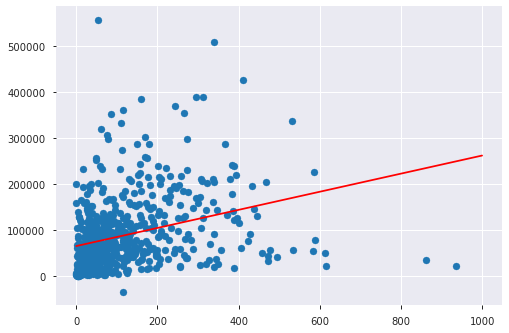

In [403]:
def shortest_distance(x1, y1, a, b, c):  
    d = (a * x1 + b * y1 + c)/ (math.sqrt(a * a + b * b))
    return d    

plt.scatter(totalTestDeaths_Statewise["Total_Deaths_per_million"],totalTestDeaths_Statewise["TotalTest_per_million"])
totalTestDeaths_Statewise["Dist"]=totalTestDeaths_Statewise.apply(lambda x: \
                                                                  shortest_distance(x.Total_Deaths_per_million, \
                                                                                    x.TotalTest_per_million,results.params[1],-1,results.params[0]), axis=1)
x=[i for i in range(1000)]
y=[ k*results.params[1] + results.params[0] for k in x]
plt.plot(x,y,color="r")
plt.show()

In [404]:
# we are only considering cases where total deaths per million is more than 100
totalTestDeaths_Statewise_above100=totalTestDeaths_Statewise[totalTestDeaths_Statewise["Total_Deaths_per_million"]>100]
totalTestDeaths_Statewise_above100=totalTestDeaths_Statewise_above100.sort_values("Dist",ascending=False)
# We are taking ~5% points which are futhermost from this line, having positive or negative differnce 
Takingtop15_points=totalTestDeaths_Statewise_above100[:15]
a=list(Takingtop15_points['state'].value_counts().index)
c=a
statesHavingBadTesting=c
print(statesHavingBadTesting)
tr=Takingtop15_points.groupby('state')['yearMonth'].apply(list)
print(tr)

['CT', 'SD', 'AL', 'NJ', 'NY', 'IA', 'MI', 'OH', 'WY', 'MA', 'LA']
state
AL    [2021-01, 2021-02]
CT    [2020-04, 2020-05]
IA             [2020-12]
LA             [2020-04]
MA             [2020-04]
MI             [2020-04]
NJ    [2020-04, 2020-05]
NY             [2020-04]
OH             [2021-02]
SD    [2020-12, 2020-11]
WY             [2021-02]
Name: yearMonth, dtype: object


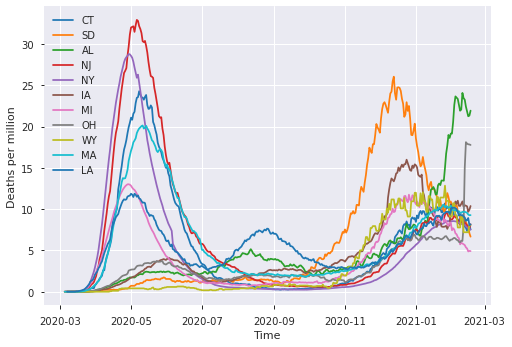

In [405]:
states=final['state'].unique()
months=final['yearMonth'].unique()
for state in statesHavingBadTesting:
    df=final[final['state']==state]
    df['deathIncrease_per_million_smooth']=df['deathIncrease_per_million'].rolling(30,min_periods=1).mean()
    plt.plot(df['date'],df['deathIncrease_per_million_smooth'],label=state)
plt.ylabel("Deaths per million")
plt.xlabel("Time")
plt.legend()
plt.show()

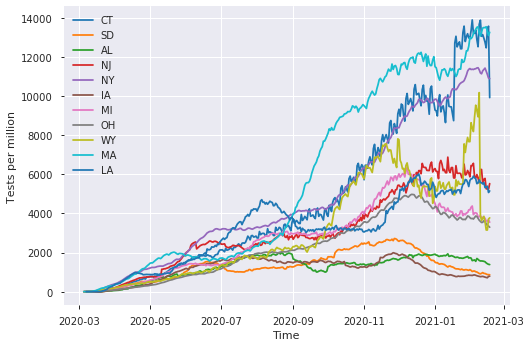

In [406]:
states=final['state'].unique()
months=final['yearMonth'].unique()
for state in statesHavingBadTesting:
    df=final[final['state']==state]
    df['TotalTest_per_million_smooth']=df['TotalTest_per_million'].rolling(30,min_periods=1).mean()
    plt.plot(df['date'],df['TotalTest_per_million_smooth'],label=state)
plt.xlabel("Time")
plt.ylabel("Tests per million")
plt.legend()
plt.show()

In [415]:
totalTestDeaths_Statewise_subset=totalTestDeaths_Statewise[totalTestDeaths_Statewise['state'].isin(statesHavingGoodBadTesting)]
alt.Chart(totalTestDeaths_Statewise_subset).mark_circle().encode(
    x="yearMonth",
    y=alt.X('TotalTest_per_million'),
    size=alt.Size("Total_Deaths_per_million"),
    color='state',
    tooltip=['state', 'yearMonth', 'Total_Deaths_per_million', 'TotalTest_per_million']
).interactive()

alt.Chart(...)

In [426]:
y=pd.DataFrame(final_after_june.groupby(["state"])["TotalTest_per_million"].mean().reset_index())
y=y.sort_values('TotalTest_per_million',ascending=True)
low_testing_states=list(y.state[:6])
high_testing_states=list(y.state[-6:])


In [430]:
final_after_june_low=final_after_june[final_after_june['state'].isin(low_testing_states)]
final_after_june_high=final_after_june[final_after_june['state'].isin(high_testing_states)]
deaths_low_testing=final_after_june_low.groupby(["date"])["deathIncrease_per_million"].sum()
deaths_high_testing=final_after_june_high.groupby(["date"])["deathIncrease_per_million"].sum()

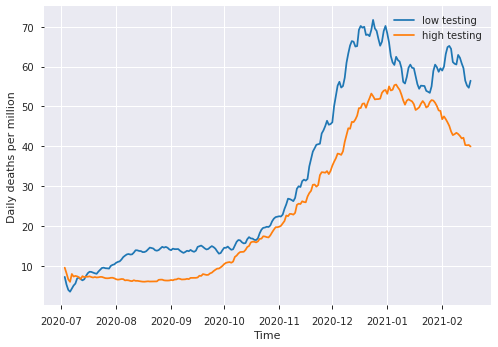

In [435]:

plt.plot(deaths_low_testing.rolling(30,min_periods=2).mean(), label="low testing ")
plt.plot(deaths_high_testing.rolling(30,min_periods=2).mean(),label="high testing")
plt.ylabel("Daily deaths per million")
plt.xlabel("Time")
plt.legend()
plt.show()

In [447]:
rv1=deaths_low_testing
rv2=deaths_high_testing
stats.ttest_rel(rv1,rv2)

Ttest_relResult(statistic=5.486655044594817, pvalue=1.0776826451280342e-07)

In [ ]:
s=pd.DataFrame(Hospital_Deaths_data_above100.groupby(["state"])["Average_Occupancy_of_inpatient_beds_per_capacity"].mean())
s=s.sort_values("Average_Occupancy_of_inpatient_beds_per_capacity",ascending=True)
low_occupancy_states=list(s.index)[:5]
high_occupancy_states=list(s.index)[5:]
print("Low occupany states on avg:")
print(low_occupancy_states)
print("High occupany states on avg:")
print(high_occupancy_states)
Hospital_Deaths_data_above100_low=Hospital_Deaths_data_above100[Hospital_Deaths_data_above100['state'].isin(low_occupancy_states)]
print(Hospital_Deaths_data_above100_low.groupby("yearMonth")["Total_Deaths_per_million"].mean())
Hospital_Deaths_data_above100_high=Hospital_Deaths_data_above100[Hospital_Deaths_data_above100['state'].isin(high_occupancy_states)]
print(Hospital_Deaths_data_above100_high.groupby("yearMonth")["Total_Deaths_per_million"].mean())


In [407]:
x=pd.DataFrame(final.groupby(["state","yearMonth"])["deathIncrease_per_million"].sum().reset_index())
y=pd.DataFrame(final.groupby(["state","yearMonth"])["total_hospitalizedCurrently_per_capacity"].mean().reset_index())
Hospital_Deaths_data=x.merge(y,on=["state","yearMonth"])
Hospital_Deaths_data.columns=["state","yearMonth","Total_Deaths_per_million","Average_Occupancy_of_inpatient_beds_per_capacity"]
alt.Chart(Hospital_Deaths_data).mark_circle(size=60).encode(
    x="Total_Deaths_per_million",
    y=alt.X('Average_Occupancy_of_inpatient_beds_per_capacity',
        scale=alt.Scale(domain=(0, 1))),
    color='state',
    tooltip=['state', 'yearMonth', 'Total_Deaths_per_million', 'Average_Occupancy_of_inpatient_beds_per_capacity']
).interactive()

alt.Chart(...)

In [408]:
X=np.array(Hospital_Deaths_data.Total_Deaths_per_million)
y=np.array(Hospital_Deaths_data.Average_Occupancy_of_inpatient_beds_per_capacity)
X = sm.add_constant(X)
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.260
Model:                            OLS   Adj. R-squared:                  0.259
Method:                 Least Squares   F-statistic:                     218.9
Date:                Sun, 21 Feb 2021   Prob (F-statistic):           1.15e-42
Time:                        22:36:38   Log-Likelihood:                 734.86
No. Observations:                 624   AIC:                            -1466.
Df Residuals:                     622   BIC:                            -1457.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5293      0.004    130.291      0.0

In [409]:
Hospital_Deaths_data.head()

,state,yearMonth,Total_Deaths_per_million,Average_Occupancy_of_inpatient_beds_per_capacity
0,AK,2020-03,4.100910,0.501673
1,AK,2020-04,8.201819,0.512533
2,AK,2020-05,1.366970,0.511992
3,AK,2020-06,5.467880,0.513546
4,AK,2020-07,12.302729,0.527593


In [410]:
Hospital_Deaths_data["Dist"]=Hospital_Deaths_data.apply(lambda x: \
                                                                  shortest_distance(x.Total_Deaths_per_million, \
                                                                                    x.Average_Occupancy_of_inpatient_beds_per_capacity,results.params[1],-1,results.params[0]), axis=1)
Hospital_Deaths_data=Hospital_Deaths_data.sort_values("Dist",ascending=False)
bad_Hospital_policy_states=Hospital_Deaths_data[:30]
tr=bad_Hospital_policy_states.groupby('state')['yearMonth'].apply(list)
print(tr)

state
IA                                   [2020-12, 2021-01]
IN                                            [2021-02]
KS                          [2020-12, 2021-01, 2021-02]
ND    [2020-12, 2021-01, 2020-10, 2020-11, 2020-09, ...
OH                                            [2021-02]
SD    [2021-01, 2020-03, 2020-12, 2020-04, 2020-07, ...
WY                                   [2021-01, 2021-02]
Name: yearMonth, dtype: object


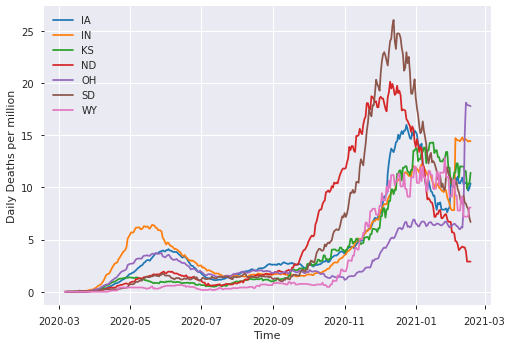

In [411]:
bad_Hospital_policy_states=tr.index
months=final['yearMonth'].unique()
for state in bad_Hospital_policy_states:
    df=final[final['state']==state]
    df['Deaths_per_million_smooth']=df['deathIncrease_per_million'].rolling(30,min_periods=2).mean()
    #df['total_hospitalizedCurrently_per_capacity_smooth']=df['total_hospitalizedCurrently_per_capacity'].rolling(30,min_periods=2).mean()
    plt.plot(df['date'],df['Deaths_per_million_smooth'],label=state)
plt.xlabel("Time")
plt.ylabel("Daily Deaths per million")
plt.legend()
plt.show()

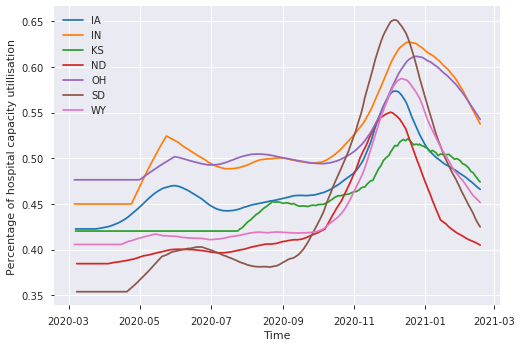

In [412]:
for state in bad_Hospital_policy_states:
    df=final[final['state']==state]
    df['total_hospitalizedCurrently_per_capacity_smooth']=df['total_hospitalizedCurrently_per_capacity'].rolling(30,min_periods=2).mean()
    plt.plot(df['date'],df['total_hospitalizedCurrently_per_capacity_smooth'],label=state)
plt.xlabel("Time")
plt.ylabel("Percentage of hospital capacity utillisation")
plt.legend()
plt.show()

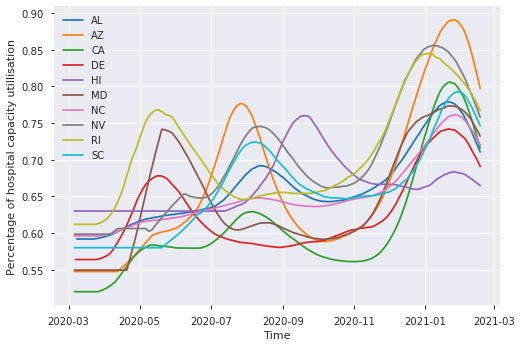

In [413]:
Good_Hospital_policy_states=Hospital_Deaths_data[-30:]
goodstates= Good_Hospital_policy_states.groupby('state')['yearMonth'].apply(list)
good_Hospital_policy_states=list(goodstates.index)
months=final['yearMonth'].unique()
for state in good_Hospital_policy_states:
    df=final[final['state']==state]
    #df['TotalDeaths_per_million_smooth']=df['Total_Deaths_per_million'].rolling(30,min_periods=2).mean()
    df['total_hospitalizedCurrently_per_capacity_smooth']=df['total_hospitalizedCurrently_per_capacity'].rolling(30,min_periods=2).mean()
    plt.plot(df['date'],df['total_hospitalizedCurrently_per_capacity_smooth'],label=state)
plt.xlabel("Time")
plt.ylabel("Percentage of hospital capacity utillisation")
plt.legend()
plt.show()

In [414]:
bad_Hospital_policy_states=list(bad_Hospital_policy_states)
bad_Hospital_policy_states.append("NY")
X=Hospital_Deaths_data[Hospital_Deaths_data['state'].isin(bad_Hospital_policy_states)]
alt.Chart(X).mark_circle().encode(
    x="yearMonth",
    y=alt.X('Average_Occupancy_of_inpatient_beds_per_capacity'),
    size=alt.Size("Total_Deaths_per_million"),
    color='state',
    tooltip=['state', 'yearMonth', 'Total_Deaths_per_million', 'Average_Occupancy_of_inpatient_beds_per_capacity']
).interactive()

alt.Chart(...)

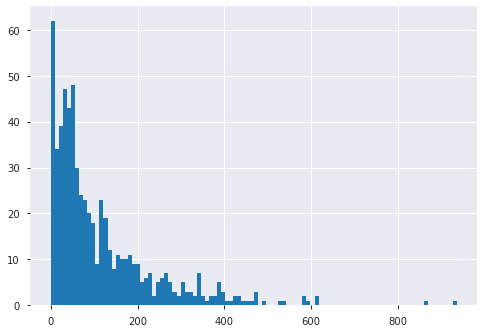

In [354]:
plt.hist(Hospital_Deaths_data['Total_Deaths_per_million'],bins=100)
plt.show()

In [366]:
#From the above graph we can see that for most of the months in most states the 
#deaths per million is close to zero and we want to do hypothesis testing only for cases
# when there is peak in covid cases, we have take a threshold of 100 deaths per million 
# per month, per state. 
Hospital_Deaths_data_above100=Hospital_Deaths_data[Hospital_Deaths_data['Total_Deaths_per_million']>100]
s=pd.DataFrame(Hospital_Deaths_data_above100.groupby(["state"])["Average_Occupancy_of_inpatient_beds_per_capacity"].mean())
s=s.sort_values("Average_Occupancy_of_inpatient_beds_per_capacity",ascending=True)
low_occupancy_states=list(s.index)[:5]
high_occupancy_states=list(s.index)[5:]
print("Low occupany states on avg:")
print(low_occupancy_states)
print("High occupany states on avg:")
print(high_occupancy_states)
Hospital_Deaths_data_above100_low=Hospital_Deaths_data_above100[Hospital_Deaths_data_above100['state'].isin(low_occupancy_states)]
print(Hospital_Deaths_data_above100_low.groupby("yearMonth")["Total_Deaths_per_million"].mean())
Hospital_Deaths_data_above100_high=Hospital_Deaths_data_above100[Hospital_Deaths_data_above100['state'].isin(high_occupancy_states)]
print(Hospital_Deaths_data_above100_high.groupby("yearMonth")["Total_Deaths_per_million"].mean())


               

Low occupany states on avg:
['ND', 'ID', 'KS', 'IA', 'WY']
High occupany states on avg:
['WI', 'IN', 'VT', 'PR', 'SD', 'OH', 'MN', 'AR', 'UT', 'OK', 'CT', 'MI', 'NE', 'CO', 'NH', 'IL', 'MT', 'MO', 'MS', 'FL', 'OR', 'ME', 'KY', 'AK', 'LA', 'VA', 'PA', 'DC', 'NJ', 'TN', 'NY', 'WA', 'GA', 'TX', 'MA', 'DE', 'WV', 'NM', 'SC', 'AL', 'MD', 'NC', 'CA', 'RI', 'NV', 'AZ']
yearMonth
2020-05    117.905466
2020-08    101.842966
2020-09    133.847377
2020-10    201.936996
2020-11    263.166090
2020-12    399.947694
2021-01    266.073528
2021-02    165.698231
Name: Total_Deaths_per_million, dtype: float64
yearMonth
2020-04    373.090227
2020-05    250.446140
2020-06    149.135600
2020-07    169.993960
2020-08    176.851750
2020-09    136.810916
2020-10    145.427529
2020-11    181.836447
2020-12    250.269768
2021-01    274.197023
2021-02    176.933793
Name: Total_Deaths_per_million, dtype: float64


In [ ]:
Hospital_Deaths_data_above100.groupby(["state"])

In [428]:
final.columns

Index(['date', 'state', 'death', 'deathConfirmed', 'deathIncrease',
       'deathProbable', 'hospitalized', 'hospitalizedCumulative',
       'hospitalizedCurrently', 'hospitalizedIncrease', 'inIcuCumulative',
       'inIcuCurrently', 'negative', 'negativeIncrease',
       'negativeTestsAntibody', 'negativeTestsPeopleAntibody',
       'negativeTestsViral', 'onVentilatorCumulative', 'onVentilatorCurrently',
       'positive', 'positiveCasesViral', 'positiveIncrease', 'positiveScore',
       'positiveTestsAntibody', 'positiveTestsAntigen',
       'positiveTestsPeopleAntibody', 'positiveTestsPeopleAntigen',
       'positiveTestsViral', 'recovered', 'totalTestEncountersViral',
       'totalTestEncountersViralIncrease', 'totalTestResults',
       'totalTestResultsIncrease', 'totalTestsAntibody', 'totalTestsAntigen',
       'totalTestsPeopleAntibody', 'totalTestsPeopleAntigen',
       'totalTestsPeopleViral', 'totalTestsPeopleViralIncrease',
       'totalTestsViral', 'totalTestsViralIncrease'